In [39]:
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI, ChatOpenAI
import os
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer # type: ignore
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
# from langchain.globals import set_llm_cache
from langchain_community.cache import InMemoryCache
from langchain_core.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_core.output_parsers import StrOutputParser
import tqdm
load_dotenv()

True

In [86]:
# llm = AzureChatOpenAI(openai_api_version=os.environ.get("AZURE_OPENAI_VERSION", "2023-07-01-preview"),
#     azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT", "gpt4chat"),
#     azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://gpt-4-trails.openai.azure.com/"),
#     api_key=os.environ.get("AZURE_OPENAI_KEY"))

In [2]:
llm = ChatOpenAI(
    model = "gpt-3.5-turbo",
    temperature = 0.4,
    max_tokens = 400,
)
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [3]:
file_path = "policy_data.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()

In [4]:
len(pages)

44

In [5]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=50,
    length_function=len,
)

In [6]:
pages_text = [pages.page_content for pages in pages]
# the type of pages is documents but we need to convert them into list of strings for splitting the text.

In [7]:
documents = splitter.create_documents(pages_text)
# splitting the text into chunks of 250 characters and 50 characters overlap.

In [8]:
print(documents[2])

page_content='About the policy\nThe policy is made up of:\n >This booklet.\n >Your car insurance details.\n >Your certificate (or certificates)  \nof motor insurance.\nIf the policy includes Green Flag breakdown cover:\n >Your breakdown cover and your car \ninsurance are part of the same policy.\n >The policy also includes the Green Flag \npolicy booklet we’ve given you.\nIf you have a policy that includes DriveSure:\n >The policy also includes the DriveSure terms \nand conditions we’ve given you.\nPlease read all these documents carefully  and keep them safe in case you need them.Words in bold type\nSome of the words and phrases we use in \nthis booklet have a specific meaning – for example, your car or modifications.'


In [10]:
def get_vectorstore(text_chunks):
    # Check if the FAISS index file already exists
    if os.path.exists("faiss_index"):
        embeddings = OpenAIEmbeddings()
        # Load the existing FAISS index
        vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True) # used this because it is my local desktop mode
        print("Loaded existing FAISS index.")
    else:
        # Create a new FAISS index
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.from_documents(documents=text_chunks, embedding=embeddings)
        # Save the new FAISS index locally
        vectorstore.save_local("faiss_index")
        print("Created and saved new FAISS index.")
    return vectorstore

In [11]:
vectorstore = get_vectorstore(documents).as_retriever()

Loaded existing FAISS index.


In [12]:
template = """Use the context below to answer the question.
Keep the answer concise and to the point.
If you are unsure about the answer, just say i do not know the answer to the question do not create your own answer and make sure the answer is concise and to the point.
Summarize the information such that main points are covered and if you think that there needs to be some more information added to the answer then you can add that information as well.
{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

In [13]:
chain_type_kwargs = {"prompt": prompt}
chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type="stuff",
    retriever=vectorstore,
    chain_type_kwargs=chain_type_kwargs,
)

In [14]:
import pandas as pd
df = pd.read_excel('/Users/siddartha/Desktop/github/Athina_AI_project/dataset_testing/dataset_for_testing.xlsx')

In [15]:
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

In [16]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in vectorstore.get_relevant_documents(query, top_k=5)])

dataset = Dataset.from_dict(data)

/Users/siddartha/miniforge3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [17]:
df = pd.DataFrame(dataset)

In [18]:
df['answer'] = df['answer'].apply(lambda x: x['result'])

In [19]:
df.to_csv('/Users/siddartha/Desktop/github/Athina_AI_project/dataset_testing/final_dataset_testing.csv', index=False)

In [20]:
dataset = Dataset.from_pandas(df)

In [29]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=10, max_wait=100, max_workers=1)

result = evaluate(
    dataset = dataset,
    llm = llm,
    embeddings=embeddings,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

Failed to parse output. Returning None.


In [30]:
result

{'faithfulness': 0.8067, 'answer_relevancy': 0.9225}

/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/Users/siddartha/miniforge3/lib/python3.10/site-packages/matplotlib/_api/__init__.py:124: RuntimeWarning: coroutine 'Executor.wrap_callable_with_index.<locals>.wrapped_callable_async' was never awaited
  for key, val in kwargs.items():
Exception ignored in: <coroutine object as_completed.<locals>.sema_coro at 0x1754d95b0>
Traceback (most recent call last):
  File "/Users/siddartha/miniforge3/lib/python3.10/site-packages/ragas/executor.py", line 36, in sema_coro
    async with semaphore:
  File "/Users/siddartha/miniforge3/lib/python3.10/asyncio/locks.py", lin

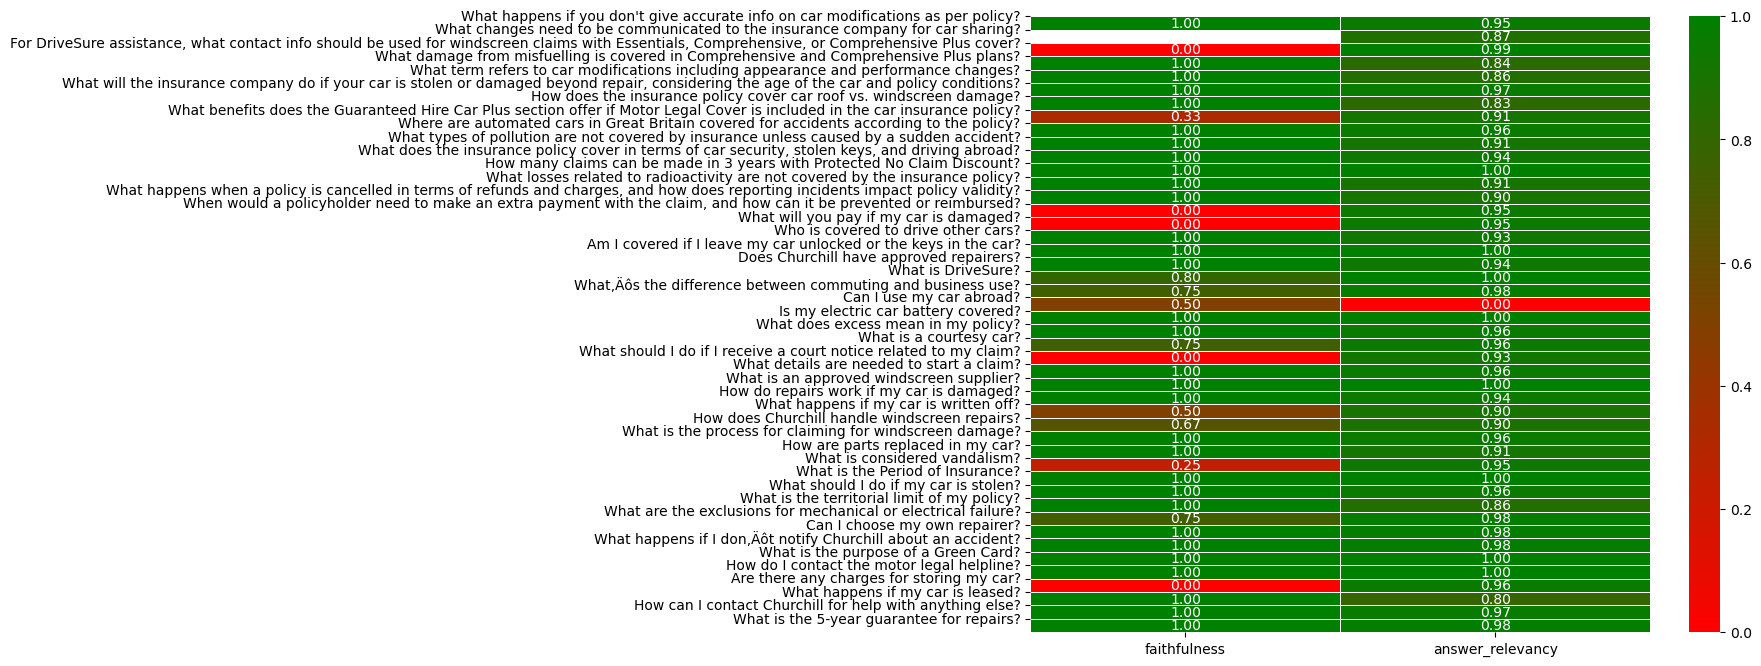

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

In [34]:
chain_type_kwargs = {"prompt": prompt}
chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type="stuff",
    retriever=vectorstore,
    chain_type_kwargs=chain_type_kwargs,
)

In [37]:
result = chain.invoke("summarize the document about drivesure?")

In [38]:
print(result)

{'query': 'summarize the document about drivesure?', 'result': 'DriveSure is a telematics insurance product that captures how, when, and where your car is driven. It provides feedback on your driving style based on driver-monitoring technology. The DriveSure policy includes the DriveSure terms and conditions, your car insurance details, and your certificate of motor insurance.'}


In [40]:
template = """Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. Your goal is to generate questions that are semantically similar to the original question. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt = PromptTemplate.from_template(template)

In [41]:
generate_queries = (
    prompt 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [51]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "Where are automated cars in Great Britain covered for accidents according to the policy?"
retrieval_chain = generate_queries | vectorstore.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})

In [52]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """
Use the context below to answer the question.
Keep the answer concise and to the point.
If you are unsure about the answer, just say i do not know the answer to the question do not create your own answer and make sure the answer is concise and to the point.
Summarize the information such that main points are covered and if you think that there needs to be some more information added to the answer then you can add that information as well.

{context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_1 = final_rag_chain.invoke({"question":question})

In [53]:
print(final_1)

Automated cars in Great Britain are covered for accidents when they are lawfully driving themselves on a road or other public place in Great Britain according to the policy.


In [55]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(final_rag_chain.invoke({"question": query}))
    data["contexts"].append([doc.page_content for doc in vectorstore.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)

In [56]:
df = pd.DataFrame(dataset)

In [58]:
dataset = Dataset.from_pandas(df)

In [59]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=10, max_wait=100, max_workers=1)

result = evaluate(
    dataset = dataset,
    llm = llm,
    embeddings=embeddings,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

In [60]:
result

{'faithfulness': 0.8115, 'answer_relevancy': 0.9487}

/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


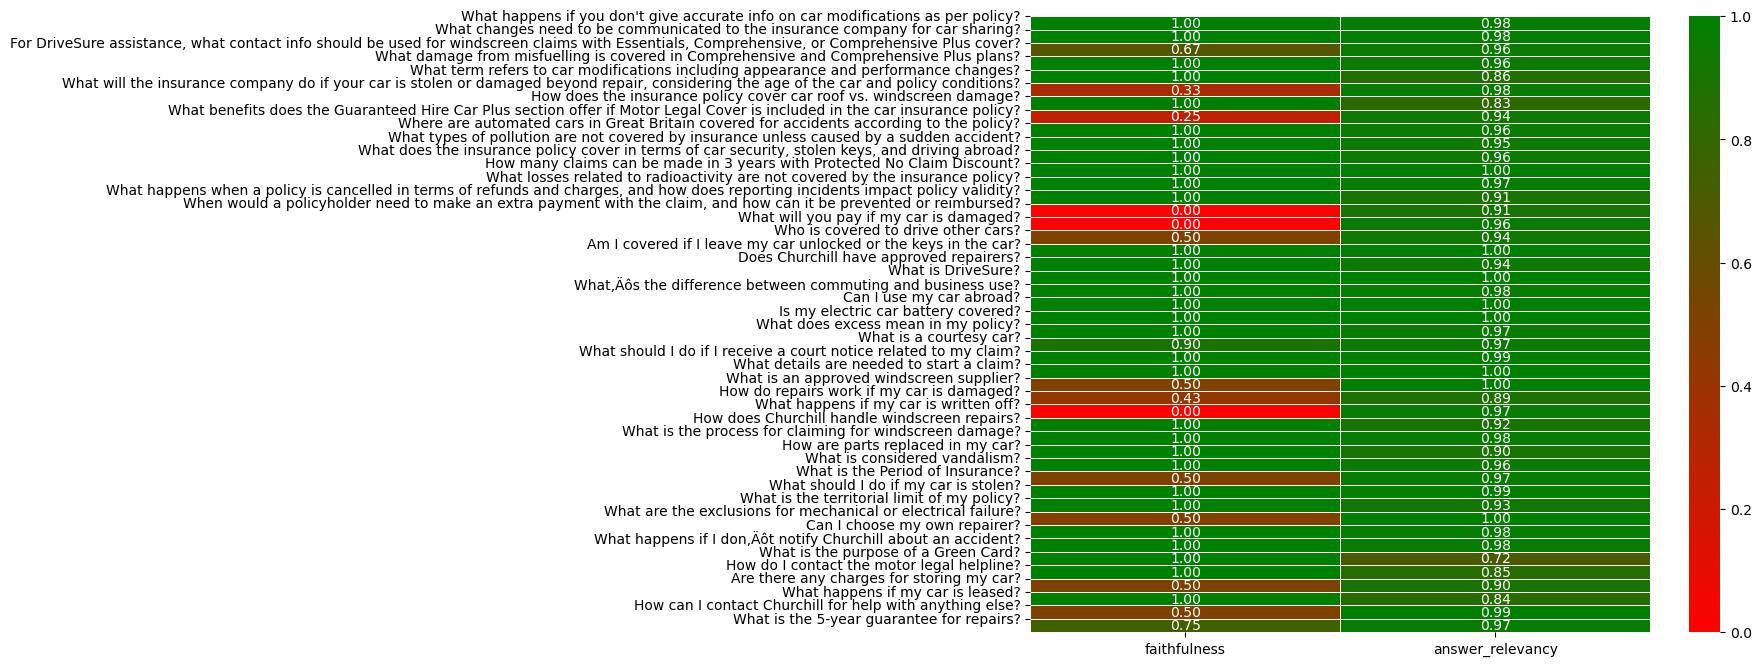

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

In [70]:
# HyDE document genration
template = """Please write a professional / scientific document based on the question in a passage format.
Question: {question}
Passage:"""
prompt_hyde = PromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | llm | StrOutputParser() 
)

# Run
question = "Are there any charges for storing my cars that user needs to pay?"
generate_docs_for_retrieval.invoke({"question":question})

'In order to provide clarity on the matter of charges for storing cars, it is important to note that there may be fees associated with storing vehicles in certain facilities or parking lots. These charges can vary depending on the location, duration of storage, and any additional services provided.\n\nIt is recommended that individuals inquire about any potential fees or charges before deciding to store their cars in a particular facility. This information can typically be obtained by contacting the facility directly or reviewing their terms and conditions.\n\nIn some cases, storage fees may be included in the overall cost of renting a parking space or storage unit. However, it is always best to confirm this information in advance to avoid any unexpected costs.\n\nOverall, while there may be charges for storing cars in certain facilities, these fees are typically transparent and can be easily understood by individuals seeking to utilize such services. By being proactive in researching 

In [71]:
retrieval_chain = generate_docs_for_retrieval | vectorstore 
retireved_docs = retrieval_chain.invoke({"question":question})
print(retireved_docs)

[Document(page_content='Removing, delivering and storing your car\nIf we’re dealing with your claim under sections 2 \nor 4 of your  policy and your car can’t be driven, \nwe’ll cover reasonable costs to take it to the nearest suitable repairer. \nWe’ll help you and your passengers make \narrangements to get home, to your original destination or take you to a safe place.\nWe’ll also cover the reasonable cost of delivering your car to you (at the address shown \non your car insurance details) after it’s repaired.\nIf we need to put your car into safe storage at \nany time, we’ll cover the reasonable cost of storage.\nIf your car is written off\nIf your car is written off and we agree to settle'), Document(page_content='Changing your policy\nYou can make a temporary or permanent change to the policy at any time during the \nyear. \nIf you do this, you may have to pay an \nadministration fee as well as any additional premium. Please see your car insurance details\nfor more information on 

In [72]:
final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

f = final_rag_chain.invoke({"context":retireved_docs,"question":question})

In [74]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(final_rag_chain.invoke({"context":retireved_docs,"question": query}))
    data["contexts"].append([doc.page_content for doc in vectorstore.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)

In [75]:
df = pd.DataFrame(dataset)

In [76]:
dataset = Dataset.from_pandas(df)

In [77]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=10, max_wait=100, max_workers=1)

result = evaluate(
    dataset = dataset,
    llm = llm,
    embeddings=embeddings,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.


In [78]:
result

{'faithfulness': 0.4553, 'answer_relevancy': 0.4708}

/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


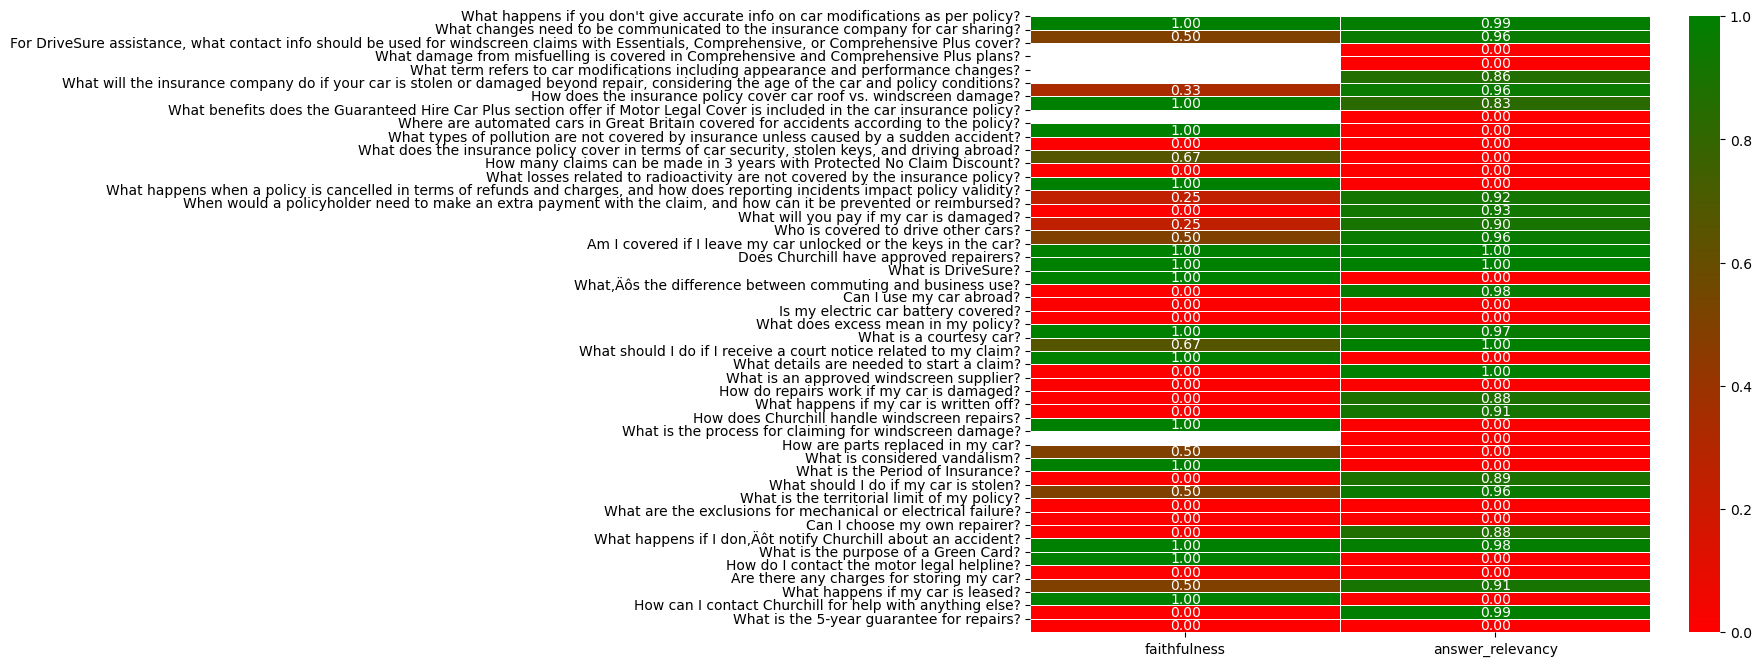

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

In [83]:
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = PromptTemplate.from_template(template)

In [84]:
generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [85]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

question = "Are there any charges for storing my cars that user needs to pay?"
retrieval_chain_rag_fusion = generate_queries | vectorstore.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

9

In [86]:
template = """
Use the context below to answer the question.
Keep the answer concise and to the point.
If you are unsure about the answer, just say i do not know the answer to the question do not create your own answer and make sure the answer is concise and to the point.
Summarize the information such that main points are covered and if you think that there needs to be some more information added to the answer then you can add that information as well.

{context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'No, the insurance policy covers the reasonable cost of storing your car if needed.'

In [87]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(final_rag_chain.invoke({"context":retireved_docs,"question": query}))
    data["contexts"].append([doc.page_content for doc in vectorstore.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)

In [88]:
df = pd.DataFrame(dataset)

In [89]:
dataset = Dataset.from_pandas(df)

In [90]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=10, max_wait=100, max_workers=1)

result = evaluate(
    dataset = dataset,
    llm = llm,
    embeddings=embeddings,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

No statements were generated from the answer.


In [91]:
result

{'faithfulness': 0.8033, 'answer_relevancy': 0.9552}

/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


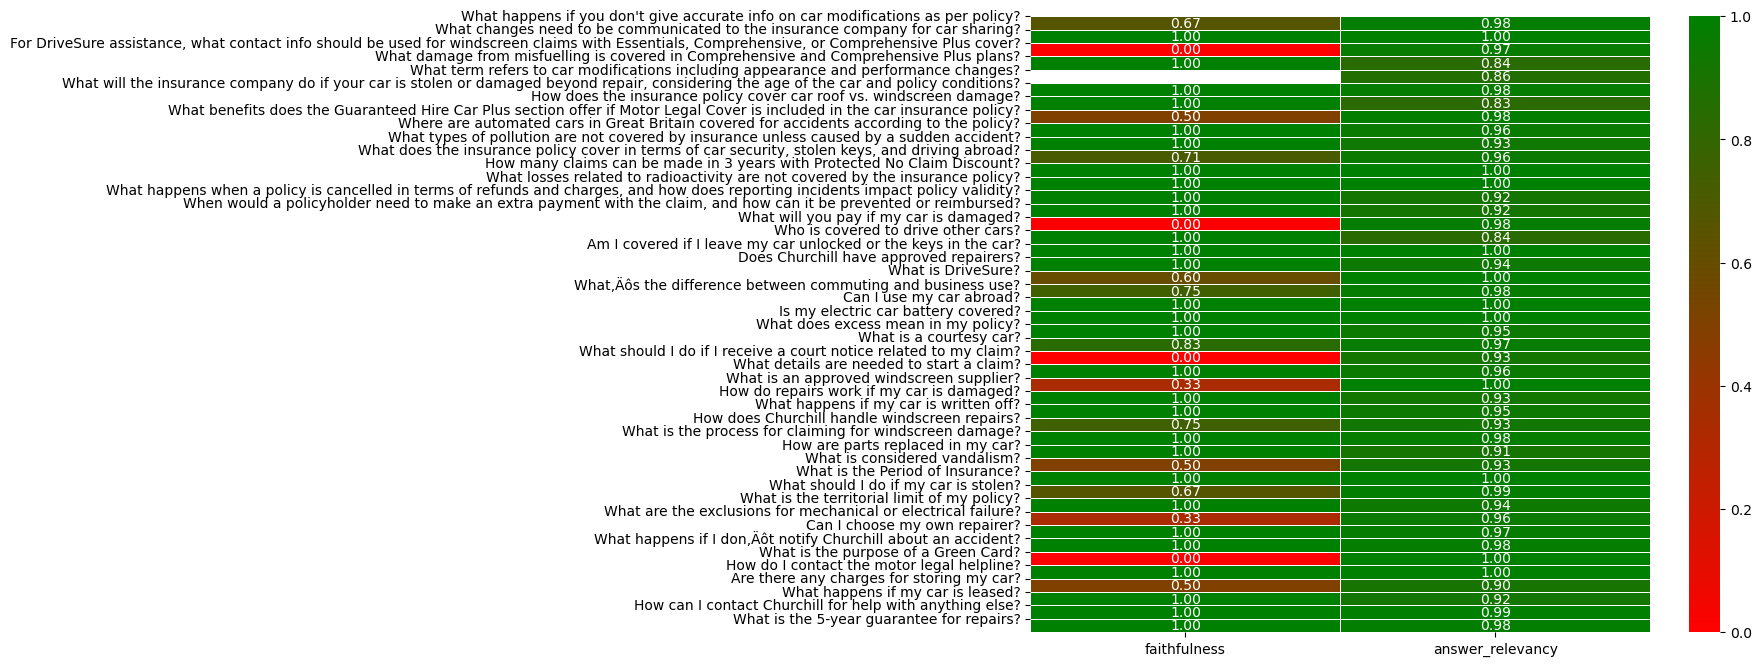

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()